# Jargon & Citations in Philosophy


In [25]:
import metaknowledge as mk
import pandas as pd
import numpy as np
from random import randint
import datetime
import copy
from sklearn.cluster import KMeans
import shelve

import umap
from scipy import stats

from tqdm import tqdm_notebook as tqdm

from enstop import EnsembleTopics

from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy

import math
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
from IPython.display import Latex
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython


from sklearn.metrics import pairwise_distances
import gc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.cluster import adjusted_rand_score, mutual_info_score

import re
from joblib import Parallel, delayed
import multiprocessing
#Embedding:
#Clustering:
import hdbscan
from sklearn.decomposition import TruncatedSVD


import umap
import colorcet as cc
from matplotlib import colors
from faerun import Faerun, host


    
import textwrap
import cmocean

from titlecase import titlecase


import re

from matplotlib.ticker import ScalarFormatter

from wordfreq import word_frequency



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Loading Data

Here we load the data. I have sampled this for another project:

In [228]:
RC = mk.RecordCollection(r"C:\Users\noich\ucloud\ucloud_documents\phil_complete", quietStart = False)

In [230]:
drc = pd.DataFrame(RC.makeDict()).merge(pd.DataFrame.from_dict(RC.forNLP()),left_index =True,right_index=True)


We clean the data, remove articles that miss abstracts, non-english articles and articles without citation-counts or publication-year.

In [231]:
drc['source_no'] =[len(x) for x in drc['CR'].fillna(' ')]
drc = drc.dropna(subset=['title'])
drc = drc[drc['LA'] == 'English']
drc = drc.iloc[np.where(drc['abstract'].str.len()>50)[0]]

drc = drc.dropna(subset=['abstract'])
drc = drc.dropna(subset=['PY','Z9'])

drc = drc[["Philosophy" in x for x in drc['WC']]]
rc = drc.reset_index()


# Correcting citation-counts for age

In [ ]:
citation_counts_df = drc['Z9'].value_counts().rename_axis('unique_values').reset_index(name='counts')


We plot the distribution of citations, to get a rough idea. We also take a look at the mean citation-count of papers published in 2010, which at the time of sampling should have been roughly ten years old.


6.45


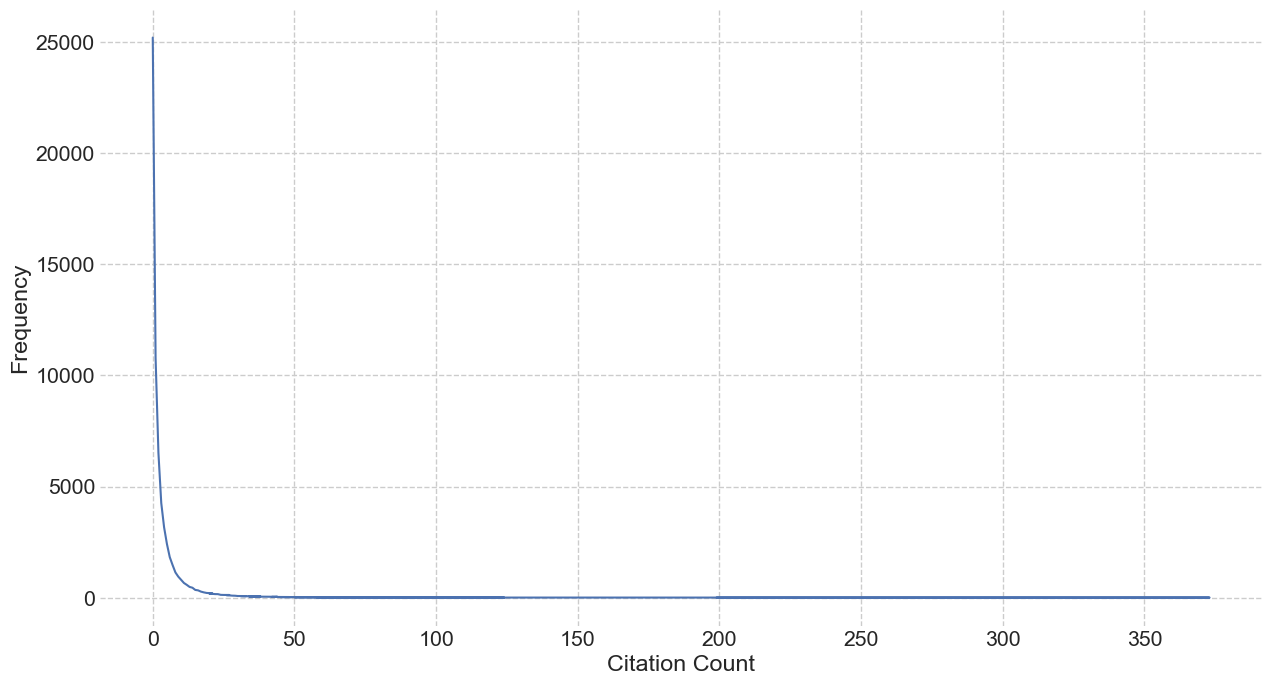

In [233]:


sns.set(font="Source Sans Pro",font_scale=1.4)
plt.style.use("seaborn-whitegrid")
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['figure.figsize'] = (15,8)
f, ax = plt.subplots()

# sns.distplot(drc['Z9'])
plt.plot(citation_counts_df['unique_values'],citation_counts_df['counts'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.set(xscale="symlog")

# ax.set_xlim(0,np.max(drc['Z9']))
plt.xlabel('Citation Count')
plt.ylabel('Frequency')
ax.xaxis.set_major_formatter(ScalarFormatter())
print(np.round(np.mean((drc[drc['PY']==2010]['Z9'])),decimals=2)) 

Now we plot citation-counts against age. Unsurprisingly, older papers are more highly cited.

Text(0, 0.5, 'Citation count (log)')

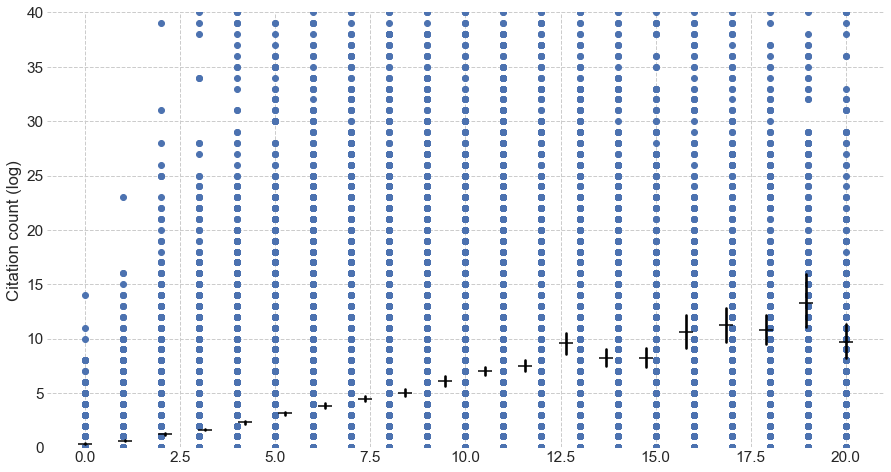

In [11]:
sns.set(font="Source Sans Pro",font_scale=1.4)
plt.style.use("seaborn-whitegrid")
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['figure.figsize'] = (15,8)
f, ax = plt.subplots()


age = (np.max(drc['PY'])-drc['PY']).values.reshape(-1,1)
cit_count = drc['Z9'].values

plt.scatter(np.max(drc['PY'])-drc['PY'],drc['Z9'])

ax = sns.regplot(x=age, y=cit_count,
            scatter_kws={"s": 200,'alpha':1,'color':'black'}, marker="_",color='black',
                 x_bins=np.linspace(np.min(age),
                                    np.max(age),20)
                 ,fit_reg=False,x_estimator=np.mean,x_ci=95)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.set(yscale="log")
ax.set_ylim(0,40)
plt.xlabel('')
plt.ylabel('Citation count (log)')

To correct for this, we fit a poisson model to the citation-counts dependent on age. The residuals of this model are what we will use in our analysis. They basically tell us how well-cited a paper is in relation to those of the same age, with negative values suggesting under-, and positive ones over-performance:

In [12]:
from pygam import PoissonGAM
gam = PoissonGAM().gridsearch(age, cit_count)
#(I think this is overfit,  check back later). 

100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


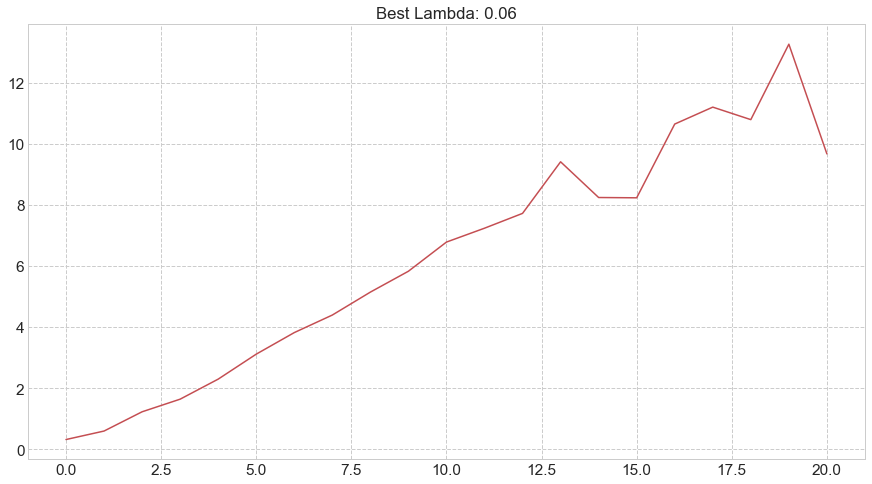

In [13]:
plt.plot(np.unique(age), gam.predict(np.unique(age)), color='r')
plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));

In [14]:
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     19.8081
Link Function:                          LogLink Log Likelihood:                               -332303.4437
Number of Samples:                        64813 AIC:                                           664646.5037
                                                AICc:                                          664646.5177
                                                UBRE:                                              10.3312
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2117
Feature Function                  Lam

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


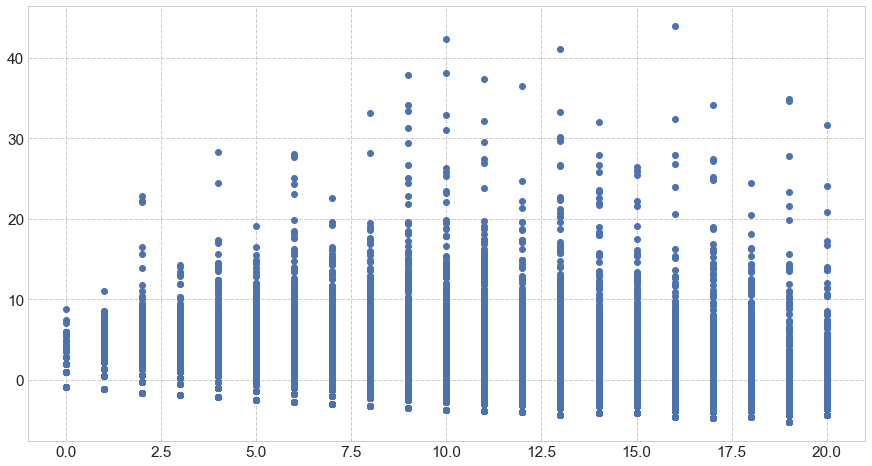

In [15]:
residuals = gam.deviance_residuals(age, cit_count)
plt.scatter(age,residuals)

# Analysing titles
Now we loop over all titles in our datasets, and get the zipf-frequency for the words that nltk doesn't mark as stopwords.

In [78]:
import nltk
from nltk.corpus import stopwords
from wordfreq import zipf_frequency
my_stopwords = stopwords.words('english')


In [79]:
title_data = []
for this_title in tqdm(drc['TI']):
    this_title_dict = {}
    this_title_dict['title'] = this_title
    
    
    this_title = re.sub('[?:]','',this_title).lower()
    title_words = this_title.split(' ')
#     title_words = [ps.stem(x) for x in title_words]
    this_title_dict['title_len'] = len(title_words)
    
    jargon  = []
    word_frequencies = []
    for word in title_words:
        if word not in my_stopwords:
            word_frequencies.append(zipf_frequency(word, 'en'))
        if word in jargon_words:
            jargon.append(word)
    this_title_dict['jargon'] = jargon
    this_title_dict['jargon_len'] = len(jargon)
    this_title_dict['mean_general_word_frequency'] = np.mean(word_frequencies)
    this_title_dict['median_general_word_frequency'] = np.median(word_frequencies)



     
    title_data.append(this_title_dict)

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [80]:
title_data_frame = pd.DataFrame(title_data)
title_data_frame['cit_count'] = residuals
title_data_frame = title_data_frame.dropna() # !!! This removes titles that are only stopwords !!!


After building a dataframe from the results, we plot some examples, to get a feeling for the analysis:

In [81]:
n = 30
base_space = np.linspace(np.min(title_data_frame['mean_general_word_frequency']),
                         np.max(title_data_frame['mean_general_word_frequency']),n)

best_fits = [np.abs(title_data_frame['mean_general_word_frequency']-x).argmin() for x in base_space]
  
samples_to_plot = title_data_frame.iloc[best_fits]
pos_head_tails = list(title_data_frame['mean_general_word_frequency'].iloc[best_fits])





In [87]:
plt.style.use('default')

from matplotlib import patches
sns.set(font="Source Code Pro",font_scale=1.05)
sns.set_style("whitegrid")


fig, aa = plt.subplots(figsize=(20, 12))

#plotting the distribution

ax = sns.distplot(title_data_frame['mean_general_word_frequency'], vertical=True,bins=200,color='#f98400',
                  hist_kws={'alpha':.9})

# vals = np.array([rec.get_y() + rec.get_height()/2 for rec in ax.patches])
# norm = plt.Normalize(vals.min(), vals.max())
# colors = plt.cm.RdYlBu(norm(vals))

# for rec, col in zip(ax.patches, colors):
#     rec.set_color(col)
    

# now for the texts:
aa.scatter([0]*n,pos_head_tails,c='#f98400',marker="D")#,vmin=-0.04,vmax=0.04)
title_labels = ["\n".join(textwrap.wrap(titlecase(i),130)) for i in samples_to_plot['title']]
patch = patches.Rectangle((0, np.min(pos_head_tails)),3, 3, fill=False, alpha=0) 

aa.add_patch(patch)

aa.set_xlim(-3, 1)
aa.set_ylim(np.min(title_data_frame['mean_general_word_frequency']),
            np.max(title_data_frame['mean_general_word_frequency']))
plt.tight_layout()

aa.set_ylabel('Mean Zipf-score of words in title, excluding stopwords',color='black',size=25)
aa.set_xlabel('Density',color='black',size=25)

# ax2 = aa.twinx()

# ax2.set_ylabel('More common ⟵⟶ More uncommon',color='black',size=25)


for i in range(n):
    plt.text(-0.1, pos_head_tails[i],title_labels[i],ha='right',va='center')

# aa.set_title('Selected titles along the '+seed_b+'-'+seed_a+'-gradient',
#                      fontdict={'fontsize':20,'fontweight' : 'bold'})
# aa.set_title('Samples of titl',
#                      fontdict={'fontsize':20,'fontweight' : 'bold'})
sns.despine(left=True, bottom=True)

# axes.annotate("test", xy=(0.5, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="<->"))
plt.savefig('zipf_score_title_gradient.png', dpi = 600, bbox_inches='tight')
plt.close()

C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


![zipf_score_title_gradient_labeled.png](zipf_score_title_gradient_labeled.png)

Now we run our model. This should be similar to what Martínez and Mammola have been doing. I do leave out the WOS-category as variable though, because we already sampled on that.

In [141]:
from pygam import LinearGAM
from pygam import ExpectileGAM

X,y = title_data_frame['mean_general_word_frequency'].values.reshape(-1,1), title_data_frame['cit_count'].values.reshape(-1,1)

gam = LinearGAM().gridsearch(X, y)



100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


In [142]:
gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.3587
Link Function:                     IdentityLink Log Likelihood:                               -197671.2339
Number of Samples:                        64803 AIC:                                           395357.1852
                                                AICc:                                          395357.1871
                                                GCV:                                                 7.912
                                                Scale:                                              7.9106
                                                Pseudo R-Squared:                                   0.0024
Feature Function                  Lam

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


Then we plot the data with the model.

In [144]:
from matplotlib.ticker import ScalarFormatter

sns.set(font="Source Sans Pro",font_scale=1.4)
plt.style.use("seaborn-whitegrid")
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['figure.figsize'] = (15,15)
f, ax = plt.subplots()

for ymin in np.hstack([np.arange(-10, 0,1),np.arange(0, 10,1),np.arange(10, 100,10)]):
    ax.axhline(y=ymin, ls='--',color = 'lightgrey',alpha=0.4)
    
    
ax = sns.regplot(x='mean_general_word_frequency', y='cit_count',
            data=title_data_frame,
            scatter_kws={"s": 20,'alpha':0.3,'color':'#f98400'},fit_reg=False)

# ax = sns.regplot(x='mean_general_word_frequency', y='cit_count',
#             data=title_data_frame,
#             scatter_kws={"s": 200,'alpha':1,'color':'black'}, marker="_",color='black',
#                  x_bins=np.linspace(np.min(title_data_frame['mean_general_word_frequency']),
#                                     np.max(title_data_frame['mean_general_word_frequency']),40)
#                  ,fit_reg=False,x_estimator=np.mean,x_ci=95)



    
plt.plot(np.unique(X), gam.predict(np.unique(X)), color='black', linewidth=3)

conf = gam.confidence_intervals(np.unique(X), width=0.95, quantiles=None)

ax.fill_between(np.unique(X),conf[:,0],conf[:,1], 
                 facecolor='black', alpha=0.2,interpolate=True)

ax.axvline(x=np.mean(title_data_frame['mean_general_word_frequency']),
                        c='black', ls='--',alpha=1,linewidth=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('Mean Zipf-score of words in title, excluding stopwords')
plt.ylabel('Citations, corrected for publication age  (log-scale)')

plt.yscale('symlog')
ax.yaxis.set_major_formatter(ScalarFormatter())

# plt.minorticks_on()
# plt.grid(b=True, which='minor', color='lightgrey', linestyle='--')
# plot_min, plot_max = np.floor(np.min(title_data_frame['cit_count'])),np.ceil(np.max(title_data_frame['cit_count']))



# plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));
plt.savefig('citations_vs_zipf_titles.png', dpi = 600, bbox_inches='tight')
plt.close()

![citations_vs_zipf_titles_labeled.png](citations_vs_zipf_titles_labeled.png)

To get a feeling for how large this effect is, I tried to reverse the adjustment of the citation-counts. I'm not 100% sure how legitimate this maneuver is, so feedback would be appreciated. The general idea is: Select all specific age, in our case 10 years. Then relate absolute citation-counts to adjusted citations for papers of that age. I do this with another GAM, but this is probably overkill.

Then get the adjusted value for the minimum and maximum, and subtract the coresponding absolute values from eachother. This should indicate how large the difference in adjusted citations is in absolute numbers for papers aged 10 years.




In [159]:
range_of_interest = np.unique(X)[np.logical_and(np.unique(X)>2,np.unique(X)<6)]

minimal_corrected_citations = np.min(gam.predict(range_of_interest))
maximum_corrected_citations = np.max(gam.predict(range_of_interest))


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


minimum: citations after ten years [4.6969633]
maximum: citations after ten years [5.61394596]
Difference [0.92]


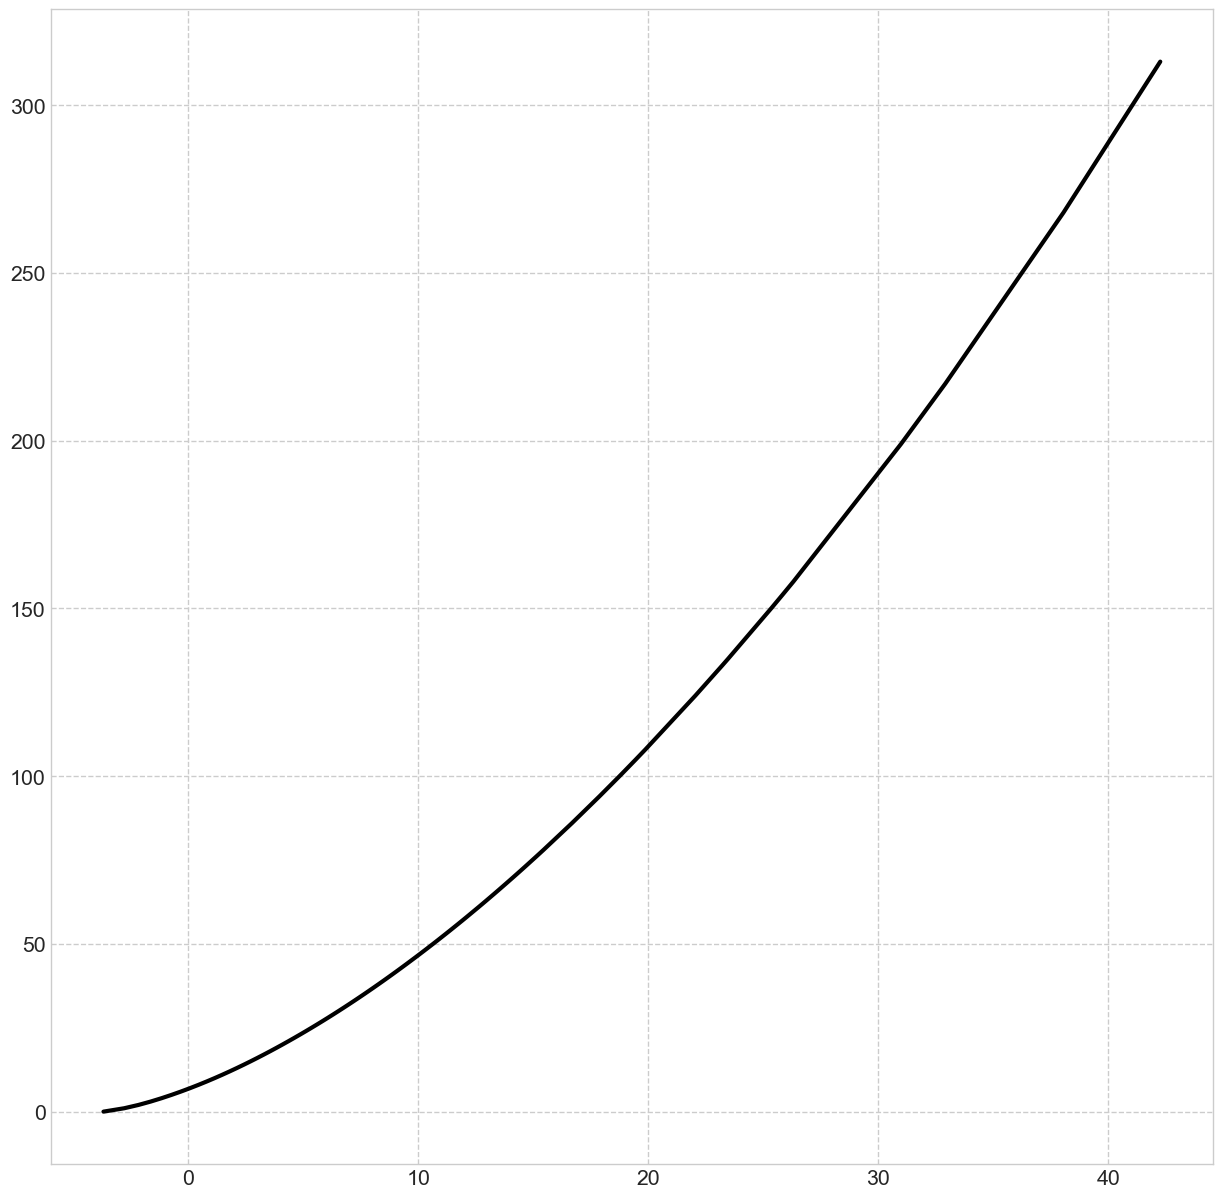

In [170]:
res_df = pd.DataFrame([residuals]).T
res_df.columns = ["residuals"]
res_df['age'] = age
res_df['cit_count'] = cit_count

res_df= res_df[res_df['age']==10]

res_df_gam = LinearGAM().gridsearch(res_df["residuals"].values.reshape(-1,1), res_df['cit_count'].values.reshape(-1,1))

plt.plot(np.unique(res_df["residuals"].values.reshape(-1,1)), res_df_gam.predict(np.unique(res_df["residuals"].values.reshape(-1,1))), color='black', linewidth=3)

print('minimum: citations after ten years',res_df_gam.predict(minimal_corrected_citations))
print('maximum: citations after ten years',res_df_gam.predict(maximum_corrected_citations))
print('Difference',np.round(res_df_gam.predict(maximum_corrected_citations)-res_df_gam.predict(minimal_corrected_citations),decimals=2))

To get some further insight into what the jargon-measurement picks up, here are some more titles, with low zipf-scores (`mean_general_word_frequency`), and higher one.

In [128]:
display(title_data_frame.sort_values(by='mean_general_word_frequency').head(49))
display(title_data_frame.sort_values(by='mean_general_word_frequency').tail(49))

,title,title_len,jargon,jargon_len,mean_general_word_frequency,median_general_word_frequency,cit_count
16160,The Irrevocability of Being,4,[],0,0.0,0.0,-3.207677
16565,On ArthApatti,2,[],0,0.0,0.0,-0.200959
27093,Against propositionalism,2,[],0,0.0,0.0,6.179226
43330,Spatiotemporaryism,1,[],0,0.0,0.0,-1.567920
54101,Trumponomics,1,[],0,0.0,0.0,-0.213701
3351,Meaning-constitutivity,1,[],0,0.0,0.0,1.676542
11958,A Mariological metametaphysics,3,[],0,0.0,0.0,-1.094927
35853,Against widescopism,2,[],0,0.0,0.0,0.917852
63453,Metaontology,1,[],0,0.0,0.0,2.110011
13853,alpha.tribe,1,[],0,0.0,0.0,-1.633894


,title,title_len,jargon,jargon_len,mean_general_word_frequency,median_general_word_frequency,cit_count
27371,What Part of 'Not' Don't We Understand?,7,[],0,5.946667,5.780,-2.143743
60413,HOW CAN WE EVER KNOW WHAT WE KNOW?,8,[],0,5.953333,6.100,-2.495958
1411,22 FEBRUARY 1984 First hour,5,[],0,5.958000,6.110,-3.929478
23012,15 FEBRUARY 1984 First hour,5,[],0,5.958000,6.110,-3.929478
19017,29 FEBRUARY 1984 First hour,5,[],0,5.958000,6.110,-3.929478
45722,I Was Right!,3,[],0,5.960000,5.960,-1.094927
63572,Work,1,[],0,5.960000,5.960,-2.964549
60016,"Being Right, and Being in the Right",7,[],0,5.960000,5.960,-3.929478
23913,Could Time be Change?,4,[],0,5.963333,6.060,-1.315012
51083,How Bad Can Good People Be?,6,[],0,5.966667,6.120,-2.764139


# Analyzing Abstracts

Now repeat all of the above for the abstracts in our dataset:

In [130]:
abstract_data = []
for this_abstract in tqdm(drc['AB']):
    this_abstract_dict = {}
    this_abstract_dict['abstract'] = this_abstract
    
    
    this_abstract = re.sub('[?:]','',this_abstract).lower()
    abstract_words = this_abstract.split(' ')
#     abstract_words = [ps.stem(x) for x in abstract_words]
    this_abstract_dict['abstract_len'] = len(abstract_words)
    
    jargon  = []
    word_frequencies = []
    for word in abstract_words:
        if word not in my_stopwords:
            word_frequencies.append(zipf_frequency(word, 'en'))
        if word in jargon_words:
            jargon.append(word)
    this_abstract_dict['jargon'] = jargon
    this_abstract_dict['jargon_len'] = len(jargon)
    this_abstract_dict['mean_general_word_frequency'] = np.mean(word_frequencies)
    this_abstract_dict['median_general_word_frequency'] = np.median(word_frequencies)



     
    abstract_data.append(this_abstract_dict)

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [131]:
abstract_data_frame = pd.DataFrame(abstract_data)


abstract_data_frame['cit_count'] = residuals

abstract_data_frame = abstract_data_frame.dropna()
# abstract_data_frame = abstract_data_frame[abstract_data_frame['cit_count']>=1]

Here we take a look at some examples:

In [132]:
abstract_data_frame = abstract_data_frame.sort_values(by='mean_general_word_frequency')

display(abstract_data_frame.head(49))
display(abstract_data_frame.tail(49))

,abstract,abstract_len,jargon,jargon_len,mean_general_word_frequency,median_general_word_frequency,cit_count
57498,Die Phanomenologie Husserls ist nicht nur als ...,161,[revision],1,1.802548,1.740,-1.094927
49367,Hegel erklart in der Wissenschaft der Logik un...,182,[],0,1.881839,1.975,-0.540625
48915,"Unter den vielen Interpreten des sog. ,Kampfes...",187,[normative],1,2.029727,2.300,-1.812256
4947,In Reason in the World: Hegel's Metaphysics an...,136,"[metaphysics, philosophical, interpretation, a...",4,2.118306,1.840,-1.812256
15210,Wittgenstein zitiert in seinen Schriften nur w...,135,[motivation],1,2.210397,1.905,-0.540625
11541,I shold like nothing that you playe the nurse ...,107,[],0,2.574462,1.720,-3.413900
20197,I criticize Richard Fumerton's fallibilist acq...,10,[acquaintance],1,2.585000,3.590,-1.026247
62844,We present an algebraic approach to canonical ...,34,"[algebraic, theorem]",2,2.661739,2.740,-2.764139
48354,The trilattice SIXTEEN3 is a natural generaliz...,28,"[entailment, entailment]",2,2.684444,2.150,1.153528
48034,We introduce the concept of a Zemanian logic a...,28,"[logic, logic]",2,2.703846,2.650,-1.567920


,abstract,abstract_len,jargon,jargon_len,mean_general_word_frequency,median_general_word_frequency,cit_count
48067,It is not known whether consciousness can affe...,166,"[consciousness, causal, conservation, physics,...",6,5.153902,5.240,-1.025577
43674,The kinds of questions that have led analytic ...,88,[analytic],1,5.154615,5.150,-2.308121
48484,The main idea described in the paper is: the a...,60,"[biological, experiment, experiment]",3,5.159655,5.190,-2.764139
62736,Particular problems connected with the notion ...,20,[],0,5.160000,5.075,-2.764139
38622,Miserable people can be great. It is very impo...,49,[],0,5.165217,5.170,-1.812256
14669,Those of us contemplating jetting off to a phi...,43,[harm],1,5.167500,5.330,-3.682829
2902,"""The most important thing I got out of my own ...",55,[ethical],1,5.168400,5.320,-3.929478
54513,The text tries to make plausible the necessity...,34,[],0,5.170556,5.310,-2.143743
64288,This paper argues that we can benefit or harm ...,85,"[harm, comparative, neutral]",3,5.174167,5.090,3.491909
47808,"It is often suggested that, since the state of...",100,[relational],1,5.178519,5.450,-0.540625


In [172]:
n = 20
base_space = np.linspace(np.min(abstract_data_frame['mean_general_word_frequency']),
                         np.max(abstract_data_frame['mean_general_word_frequency']),n)

best_fits = [np.abs(abstract_data_frame['mean_general_word_frequency']-x).argmin() for x in base_space]
  
samples_to_plot = abstract_data_frame.iloc[best_fits]
pos_head_tails = list(abstract_data_frame['mean_general_word_frequency'].iloc[best_fits])





plt.style.use('default')

from matplotlib import patches
sns.set(font="Source Code Pro",font_scale=1.05)
sns.set_style("whitegrid")


fig, aa = plt.subplots(figsize=(20, 15))

#plotting the distribution

ax = sns.distplot(abstract_data_frame['mean_general_word_frequency'], vertical=True,bins=200,color='#35b5ac',
                  hist_kws={'alpha':.9})

# vals = np.array([rec.get_y() + rec.get_height()/2 for rec in ax.patches])
# norm = plt.Normalize(vals.min(), vals.max())
# colors = plt.cm.RdYlBu(norm(vals))

# for rec, col in zip(ax.patches, colors):
#     rec.set_color(col)
    

# now for the texts:
aa.scatter([0]*n,pos_head_tails,c='#35b5ac',marker="D")#,vmin=-0.04,vmax=0.04)
abstract_labels = ["\n".join(textwrap.wrap(i[0:200] +" [...]",120)) for i in samples_to_plot['abstract']]
patch = patches.Rectangle((0, np.min(pos_head_tails)),3, 3, fill=False, alpha=0) 

aa.add_patch(patch)

aa.set_xlim(-3, 1.5)
aa.set_ylim(np.min(abstract_data_frame['mean_general_word_frequency']),
            np.max(abstract_data_frame['mean_general_word_frequency']))
plt.tight_layout()

aa.set_ylabel('Mean Zipf-score of words in abstract, excluding stopwords',color='black',size=25)
aa.set_xlabel('Density',color='black',size=25)

# ax2 = aa.twinx()

# ax2.set_ylabel('More common ⟵⟶ More uncommon',color='black',size=25)


for i in range(n):
    plt.text(-0.1, pos_head_tails[i],abstract_labels[i],ha='right',va='center')

# aa.set_abstract('Selected abstracts along the '+seed_b+'-'+seed_a+'-gradient',
#                      fontdict={'fontsize':20,'fontweight' : 'bold'})
sns.despine(left=True, bottom=True)
# axes.annotate("test", xy=(0.5, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="<->"))
plt.savefig('zipf_score_abstract_gradient.png', dpi = 500, bbox_inches='tight')
plt.close()

len(abstract_labels)

C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\noich\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


20

![zipf_score_abstract_gradient.png](zipf_score_abstract_gradient.png)

And now to plot the model:

In [255]:
from pygam import LinearGAM
from pygam import ExpectileGAM

X,y = abstract_data_frame['mean_general_word_frequency'].values.reshape(-1,1), abstract_data_frame['cit_count'].values.reshape(-1,1)

abstract_gam = LinearGAM().gridsearch(X, y)

abstract_gam.summary()




sns.set(font="Source Sans Pro",font_scale=1.4)
plt.style.use("seaborn-whitegrid")
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['figure.figsize'] = (15,15)
f, ax = plt.subplots()


ax = sns.regplot(x='mean_general_word_frequency', y='cit_count',
            data=abstract_data_frame
,
            scatter_kws={"s": 20,'alpha':0.3,'color':'#35b5ac'},fit_reg=False)


conf = abstract_gam.confidence_intervals(np.unique(X), width=0.95, quantiles=None)

plt.plot(np.unique(X), abstract_gam.predict(np.unique(X)), color='black', linewidth=3)

plt.fill_between(np.unique(X),conf[:,0],conf[:,1], 
                 facecolor='black', alpha=0.2,interpolate=True)

plt.axvline(x=np.mean(abstract_data_frame['mean_general_word_frequency']),
                        c='black', ls='--',alpha=1,linewidth=2)

plt.scatter(x=np.quantile(abstract_data_frame['mean_general_word_frequency'],0.1),
         y=abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.1))),
          linewidth=1,facecolors='none', edgecolors='black')

plt.scatter(x=np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9),
         y=abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9))),
          linewidth=1,facecolors='none', edgecolors='black')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.set(yscale="log")

plt.xlabel('Mean Zipf-score of words in abstracts, excluding stopwords')
plt.ylabel('Citations, corrected for publication age (log-scale)')
# plt.savefig('race_auth.png', dpi = 800, bbox_inches='tight')
# plt.close()

#######################


plt.yscale('symlog')
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.savefig('citations_vs_zipf_abstracts.png', dpi = 600, bbox_inches='tight')
plt.close()
#plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.3947
Link Function:                     IdentityLink Log Likelihood:                               -197652.4019
Number of Samples:                        64813 AIC:                                           395319.5931
                                                AICc:                                           395319.595
                                                GCV:                                                7.9056
                                                Scale:                                              7.9042
                                                Pseudo R-Squared:                                   0.0031
Feature Function                  Lam

![citations_vs_zipf_abstracts_labeled.png](citations_vs_zipf_abstracts_labeled.png)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


4.67336546184739
[-0.46201176]
10%: citations after ten years [4.68884357]
90%: citations after ten years [5.62044104]
Difference [0.93]


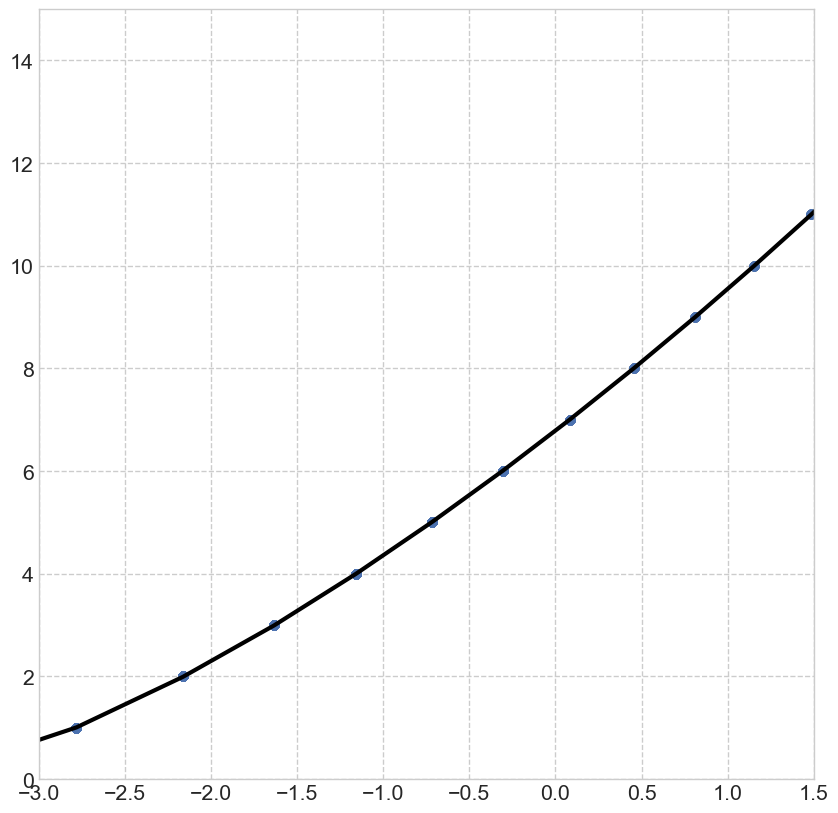

In [254]:
res_df = pd.DataFrame([residuals]).T
res_df.columns = ["residuals"]
res_df['age'] = age
res_df['cit_count'] = cit_count

res_df= res_df[res_df['age']==10]

plt.rcParams['figure.figsize'] = (10,10)
f, ax = plt.subplots()

res_df_gam = LinearGAM().gridsearch(res_df["residuals"].values.reshape(-1,1), res_df['cit_count'].values.reshape(-1,1))
plt.scatter(res_df['residuals'], res_df['cit_count'])

plt.plot(np.unique(res_df["residuals"].values.reshape(-1,1)), res_df_gam.predict(np.unique(res_df["residuals"].values.reshape(-1,1))), color='black', linewidth=3)
ax.set_xlim(-3, 1.5)
ax.set_ylim(0, 15)


print(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9))
print(abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9))))
print('10%: citations after ten years',res_df_gam.predict(abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.1)))))
print('90%: citations after ten years',res_df_gam.predict(abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9)))))

print('Difference',np.round(res_df_gam.predict(abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.9))))-
                            res_df_gam.predict(abstract_gam.predict(np.unique(np.quantile(abstract_data_frame['mean_general_word_frequency'],0.1)))),decimals=2))